# Data Wrangler for Neural Net Stock Price Problem

This notebook contains scripts that retrieve stock price data, computes a data frame with the necessary transformations and writes the dataframe to a `.csv` file.
This `.csv` file is the tidy data set that we'll use in the Stock Price Neural Network problem.

## Getting started

The organization Quandl supplies financial and economic data in several easy-to-consume formats for free. We'll get our stock price data from Quandl. To do so, first, you'll need the `quandl` python package. Get this via the following:
```pip install quandl```.

In [1]:
import pandas as pd
import quandl
import numpy as np

Next, you'll need a quandl API key, which you can obtain from [Quandl](https://docs.quandl.com/docs#section-authentication). Once you have your key, put it in a YAML file under Quandl with key 'apikey' or just replace the 'YourQuandlAPIKey' string with yours and comment out the yaml code.

In [2]:
#get my quandl api key
import yaml

#comment out the next three lines if just supply your apikey
with open('./databases.yaml', 'r') as f:
        dbparams = yaml.load(f)
apikey = dbparams['Quandl']['apikey']

#comment out three lines above if you use this
#apikey = 'YourQuandlAPIKey'

quandl.ApiConfig.api_key = apikey

## Data from Quandl

In [3]:
# 2018 data for Cisco
data = quandl.get("WIKI/CSCO", start_date = '2018-01-01')
data.tail(10)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-14,45.34,45.7587,45.0900,45.28,20923845.0,0.0,1.0,45.34,45.7587,45.0900,45.28,20923845.0
2018-03-15,45.30,45.7350,45.1200,45.33,23338222.0,0.0,1.0,45.30,45.7350,45.1200,45.33,23338222.0
2018-03-16,45.33,45.6000,44.9700,45.01,52355707.0,0.0,1.0,45.33,45.6000,44.9700,45.01,52355707.0
2018-03-19,44.59,44.8200,43.9000,44.27,24524286.0,0.0,1.0,44.59,44.8200,43.9000,44.27,24524286.0
2018-03-20,44.49,44.6400,44.1800,44.37,22385001.0,0.0,1.0,44.49,44.6400,44.1800,44.37,22385001.0
2018-03-21,44.24,44.9000,44.1331,44.31,20616375.0,0.0,1.0,44.24,44.9000,44.1331,44.31,20616375.0
2018-03-22,43.76,44.0200,43.0200,43.07,29374734.0,0.0,1.0,43.76,44.0200,43.0200,43.07,29374734.0
2018-03-23,43.71,43.8400,42.4200,42.42,30674112.0,0.0,1.0,43.71,43.8400,42.4200,42.42,30674112.0
2018-03-26,43.25,44.1600,42.8300,44.06,28454954.0,0.0,1.0,43.25,44.1600,42.8300,44.06,28454954.0


For purposes here, we'll use the __unadjusted__ Open, High, Low, Close and Volume data.

## Calcuate Moving Averages and Buy and Sell Signals

Our trading algorithm uses buy and sell signals computed from moving averages of a stock's trading price.  The model uses two moving averages, a fast one and a slow one. The number of periods in the moving average determines whether it is fast or slow. The algorithm considers that the day on which the fast moving average is greater than the slow one is the day on which to buy the stock, i.e. the transition of the fast moving average from being below the slow moving average to being above it is the buy signal. The transition of the fast from being above the slow to being below it is the sell signal.

The code below computes these crossover points. In the returned data frame, the `Crossover` column indicates whether the fast moving average moved above or below the slow moving average or maintained its position relative to the slow one. A `Crossover` value of 1 indicates the fast move above the slow, a value of 0 indicates the fast and slow maintained their relative positions and a -1 indicates that the fast fell below the slow.

The algorithm 'buys' stocks on the dates when the `Crossover` value is 1; it 'sells' them when the `Crossover` is -1.

The computations proceed as follows:
+ calculate the fast and slow moving averages of the stock's closing price using window size parameters
+ determine for each date of trading history whether the fast moving average is greater than the slow
+ compare each trading day to the previous day to determine changes in the relative positions of the fast and slow moving averages
+ tidy up by removing missing values

In [4]:
# augments and returns the stock history dataframe with a Crossover column that indicates whether the fast moving average
# changed position relative to the slow moving average, and a few intermediate column calculations

def computeCrossover(history, fast_win=9, slow_win=18):
    
    #compute moving averages based on close price
    fast = history[['Close']].rolling(window = fast_win, center=False).mean().rename(columns={'Close':'Fast'})
    slow = history[['Close']].rolling(window = slow_win, center=False).mean().rename(columns={'Close':'Slow'})
    
    #paste them on the right
    history = history.merge(fast, how='left', left_index=True, right_index=True)
    history = history.merge(slow, how='left', left_index=True, right_index=True)
    
    #compute whether the fast MA exceeds the slow MA
    history['f_gtr_s'] = (history.Fast > history.Slow)*1 # need these as ints, not booleans
    # Restore proxies (NaNs) where comparison wasn't not valid - had a NaN on either side
    history['f_gtr_s'] = np.where(np.logical_or(np.isnan(history.Fast), np.isnan(history.Slow)), np.NaN, history.f_gtr_s)
    
    # find the transition points by comparing consecutive days
    # first, add column that is the lagged MA comparison (lagged by one day)
    history['f_gtr_s_lag1'] = history.f_gtr_s.shift()
    #subtract consecutive observations to see if current observation differs from previous observation
    history['Crossover'] = history.f_gtr_s - history.f_gtr_s_lag1
    #Crossover == 1 => fast moved above slow; Crossover == -1 => fast moved below slow;
    #Crossover == 0 => fast and slow maintained their previous postions.
    
    #ditch the rows with NAs due to the trailing moving averages
    history.dropna(axis=0,inplace=True)
    
    return history


In [5]:
#get the data for the Cisco Systems for 2018
cols = ['Open','High','Low','Close','Volume'] # columns of interest
company = 'CSCO' #Cisco Systems Inc
dow_data = quandl.get('WIKI/'+company, start_date = '2018-01-01')[cols]

In [6]:
dow_data = computeCrossover(dow_data)
dow_data

,Open,High,Low,Close,Volume,Fast,Slow,f_gtr_s,f_gtr_s_lag1,Crossover
Date,,,,,,,,,,
2018-01-29,42.300,42.9800,42.3000,42.85,23053104.0,41.892222,40.876111,1.0,1.0,0.0
2018-01-30,42.685,42.8600,41.9700,42.25,25671649.0,42.008889,41.047222,1.0,1.0,0.0
2018-01-31,41.980,42.0100,41.3500,41.54,34571282.0,42.035556,41.188889,1.0,1.0,0.0
2018-02-01,41.090,42.1100,40.6700,41.70,26001606.0,42.081111,41.309444,1.0,1.0,0.0
2018-02-02,41.500,41.9500,40.8700,40.93,25920378.0,42.000000,41.364444,1.0,1.0,0.0
2018-02-05,40.870,41.4050,39.0800,39.09,39491216.0,41.665556,41.331111,1.0,1.0,0.0
2018-02-06,38.330,40.3050,37.3500,40.17,52940550.0,41.443333,41.345556,1.0,1.0,0.0
2018-02-07,40.310,41.2060,40.0300,40.34,31841942.0,41.270000,41.358889,0.0,1.0,-1.0
2018-02-08,40.440,40.7600,38.7200,38.73,39300118.0,40.844444,41.240000,0.0,0.0,0.0


### Buy Dates

The buy dates for a stock are simply the dates on which the `Crossover` value is 1:

In [7]:
def getBuy_Dates(history):
    buy_dates = history.index[history.Crossover == 1]
    return buy_dates

To demonstrate, let's look at the trading history of Cisco back to 2010.

In [8]:
#get longer history for Cisco to see all of the buy dates:
cols = ['Open','High','Low','Close','Volume'] # columns of interest
company = 'CSCO' #Cisco Systems Inc
dow_data = quandl.get('WIKI/'+company, start_date = '2010-01-01')[cols]
dow_data = computeCrossover(dow_data)
buy_dates = getBuy_Dates(dow_data)
buy_dates

DatetimeIndex(['2010-02-11', '2010-04-15', '2010-06-23', '2010-07-15',
               '2010-09-16', '2010-12-14', '2011-04-07', '2011-05-03',
               '2011-06-30', '2011-08-22', '2011-09-08', '2011-10-11',
               '2011-12-08', '2012-01-04', '2012-03-20', '2012-06-14',
               '2012-08-08', '2012-09-13', '2012-11-20', '2013-01-08',
               '2013-02-11', '2013-03-08', '2013-04-12', '2013-05-08',
               '2013-07-08', '2013-08-06', '2013-09-13', '2013-11-07',
               '2013-12-26', '2014-02-12', '2014-03-26', '2014-05-16',
               '2014-07-01', '2014-09-03', '2014-10-30', '2014-12-26',
               '2015-01-21', '2015-02-13', '2015-04-15', '2015-06-23',
               '2015-07-20', '2015-09-15', '2015-10-05', '2015-12-04',
               '2015-12-28', '2016-02-12', '2016-04-21', '2016-05-23',
               '2016-07-11', '2016-08-25', '2016-08-30', '2016-09-29',
               '2016-11-03', '2016-12-14', '2017-01-26', '2017-04-27',
      

The algorithm will want to 'buy' stocks (in the example, Cisco) on each of the days above.

The next section will discuss the disposition of the stock purchased on each of  those days.

## Sale Results

Stocks are purchased on a 'buy' signal. Once purchased, stocks are sold on the earliest of three dates:

1. 'Sell' signal (crossover value is -1 indicating that the fast moving average transitioned from being higher than the slow moving average to being below the slow moving average
1. maximum number of trading days to hold the stock has been exceeded
1. value of stock decreased below some threshold amount

The function below implements this.

In [9]:
# function to compute the result of a buy.
# given a buy date and the stock history, loss threshold, max trading days hold time,
# returns the date of sale, reason for sale and the price at sale date

def saleResult(bd,history, loss_thresh = 0.2, maxhold = 20):
    
    reasons = ['SellSig', 'MaxHold', 'LossThresh']
    future_date = pd.to_datetime('2200-12-31') # way after we're all gone
    
    # not interested in the history before the buy data
    df = history.loc[bd:] # this makes the record for the buy date the 0'th record, very handy!
    
    # first sell signal after the buy date; Crossover value of -1 is a sell signal
    ss = future_date
    sell_signals = df.index[df.Crossover == -1]
    if sell_signals.size > 0:
        ss = sell_signals[0]
    
    # max trading days
    md = future_date
    if df.index.size > maxhold:
        md = df.index[maxhold]
        
    # loss_threshold
    lt = future_date
    maxloss = 1-loss_thresh
    buy_price = df.Close[0]
    min_price = buy_price*maxloss
    lossdates = df.index[df.Close <= min_price]
    if lossdates.size > 0:
        lt = lossdates[0]
    
    # figure out which is the earliest date
    exit_dates = np.array([ss, md, lt]) # need to be in same order as reasons list
    exit_date_i = exit_dates.argmin()
    
    exit_date = exit_dates[exit_date_i]
    
    #perhaps the purchased stock hasn't sold yet
    if exit_date == future_date:
        reason = 'NotSoldYet'
        exit_price = np.NaN
    else:
        reason = reasons[exit_date_i]
        # get the exit price
        rn = df.index.get_loc(exit_date)
        exit_price = df.Close[rn]
    
    rdf = pd.DataFrame({'Sell_Date':exit_date, 'Sell_Reason': reason, 'Sell_Price':exit_price},index=[bd])
    rdf.index.name = 'Buy_Date'
    
    return rdf

Demonstrate on the last 10 buy signals of the Cisco stock:

In [10]:
n = 10
loss_thresh = 0.01 # will tolerate up to a 1% loss
maxhold = 20 # will hold the stock for up to this maximum number of trading days
results = pd.concat([saleResult(bd, dow_data, loss_thresh=loss_thresh, maxhold=maxhold) for bd in buy_dates[-n:]] )
results

,Sell_Date,Sell_Price,Sell_Reason
Buy_Date,,,
2017-01-26,2017-02-24,34.3200,MaxHold
2017-04-27,2017-05-18,31.3800,SellSig
2017-06-13,2017-06-15,31.5801,SellSig
2017-06-22,2017-06-29,31.4100,LossThresh
2017-07-21,2017-07-28,31.5200,LossThresh
2017-08-16,2017-08-17,31.0400,LossThresh
2017-09-01,2017-09-05,31.6200,LossThresh
2017-10-23,2017-11-10,33.9900,LossThresh
2017-11-16,2017-12-15,38.1900,MaxHold


## Get the HLOCV for the Purchase Date and 4 Previous Days: The Predictors

The algorithm uses the stock's High, Low, Open, Close and Volume values for the 4 days up to and including the purchase date as predictors of the outcome of a purchase and subsequent sale.

The function below produces a wide format DataFrame for the 4 days prior to the argument buy date.

In [11]:
#function to get the HLOCV info for 4 days before the buy date(bd)
#returns a wide data frame
def getPredictors(bd, history, n=5):
    
    # row in the data frame of the buy date
    indx = history.index.get_loc(bd)
    
    # column names of interest in the history dataframe
    cols = ['Open','High','Low','Close','Volume']
    # column names for the df to be returned:
    colnames = [c+'_'+str(abs(p)) for p in range(-1*(n-1),0,1)  for c in cols ] + cols
    
    #make a row vector out of the data to be returned:
    rv = history.iloc[(indx-(n-1)):indx+1][cols].values.reshape(1,-1)
    
    #handle case where there's insufficient history - just return df with all NaNs.
    if rv.size != len(colnames):
        rv = np.full((1,len(colnames)), np.nan)
    
    ldf = pd.DataFrame(rv, columns = colnames, index = [bd])
    ldf.index.name = 'Buy_Date'
    #sort the column names for aesthetics
    colnames.sort()
    
    return ldf[colnames]

Demonstrate for a buy date of 2/20/2018. First show the trading history:

In [12]:
bd = pd.to_datetime('2018-02-20')
n = 5 # window size; want the history for bd and the n-1 prior days

# row in the data frame of the buy date
indx = dow_data.index.get_loc(bd)

#columns of interest
cols = ['Open','High','Low','Close','Volume']

dow_data.iloc[(indx-(n-1)):indx+1][cols]

,Open,High,Low,Close,Volume
Date,,,,,
2018-02-13,40.500,41.31,40.22,41.23,29220084.0
2018-02-14,41.040,42.26,40.99,42.09,39880261.0
2018-02-15,45.065,45.13,43.26,44.08,71490591.0
2018-02-16,43.885,45.09,43.79,44.33,37915915.0
2018-02-20,44.000,44.69,43.81,44.06,26258211.0


Use the `getPredictors` function to get the above in wide format:

In [13]:
getPredictors(bd, dow_data)

,Close,Close_1,Close_2,Close_3,Close_4,High,High_1,High_2,High_3,High_4,...,Open,Open_1,Open_2,Open_3,Open_4,Volume,Volume_1,Volume_2,Volume_3,Volume_4
Buy_Date,,,,,,,,,,,,,,,,,,,,,
2018-02-20,44.06,44.33,44.08,42.09,41.23,44.69,45.09,45.13,42.26,41.31,...,44.0,43.885,45.065,41.04,40.5,26258211.0,37915915.0,71490591.0,39880261.0,29220084.0


### Putting the Three Pieces Together: getPurchases

The function below, `getPurchases` integrates the three function above to produce a tidy data frame. Each row of the data frame represents a stock purchase, the sale result of that stock purchase and the trading history for the days prior to the purchase. Note: this function also fetches the trading history data for the argument ticker.

In [14]:
def getPurchases(tkr, start_date='2010-01-01',
                loss_thresh = 0.2, maxhold = 20,
                fast_win=9, slow_win=18,
                covar_n=5):
    
    #get the trading data
    hist = quandl.get('WIKI/' + tkr,  start_date = start_date)
    
    #calculate the crossover points and purchase dates:
    hist = computeCrossover(hist, fast_win=fast_win, slow_win=slow_win)
    buy_dates = getBuy_Dates(hist)
    
    #get the results
    results = pd.concat([saleResult(bd,hist,loss_thresh=loss_thresh, maxhold=maxhold) for bd in buy_dates] )
    
    #get the covariates
    covars = pd.concat([getPredictors(bd, hist, n=covar_n) for bd in buy_dates])
    
    #get the purchase price
    purchase_prices = hist.loc[buy_dates,['Close']].reset_index()
    purchase_prices.rename(columns = {'Close':'Purchase_Price', 'Date':'Purchase_Date'},inplace=True)
    purchase_prices['Ticker'] = tkr
    purchase_prices = purchase_prices[ ['Ticker','Purchase_Date','Purchase_Price'] ]
    
    #paste it all together
    
    df = purchase_prices.merge(results, how='left', left_on='Purchase_Date', right_index=True)
    df['Gain_Pct'] = 100.0*(df.Sell_Price/df.Purchase_Price-1.0)
    
    df = df.merge(covars, how='left', left_on = 'Purchase_Date', right_index = True)
    
    return df

In [15]:
getPurchases('CSCO',loss_thresh=0.05).head()


,Ticker,Purchase_Date,Purchase_Price,Sell_Date,Sell_Price,Sell_Reason,Gain_Pct,Close,Close_1,Close_2,...,Open,Open_1,Open_2,Open_3,Open_4,Volume,Volume_1,Volume_2,Volume_3,Volume_4
0,CSCO,2010-02-11,23.93,2010-03-12,25.880,MaxHold,8.148767,23.93,23.76,23.89,...,23.67,23.86,23.80,23.78,23.30,42458500.0,50574100.0,60331600.0,69909000.0,99148600.0
1,CSCO,2010-04-15,27.21,2010-05-06,25.488,SellSig,-6.328556,27.21,26.88,26.44,...,27.00,26.63,26.45,26.57,26.28,47016500.0,44610100.0,42863900.0,28374400.0,34610800.0
2,CSCO,2010-06-23,22.86,2010-06-28,22.420,SellSig,-1.924759,22.86,22.97,23.34,...,23.11,23.32,23.84,23.28,23.49,54086100.0,42148200.0,54836700.0,52422500.0,52811800.0
3,CSCO,2010-07-15,23.92,2010-07-21,22.560,LossThresh,-5.685619,23.92,23.74,23.09,...,23.70,23.43,23.04,22.61,22.55,51771300.0,61467200.0,45007700.0,30563100.0,41488800.0
4,CSCO,2010-09-16,21.93,2010-10-14,23.070,MaxHold,5.198358,21.93,21.59,21.45,...,21.58,21.54,21.36,20.92,20.63,47579200.0,60902400.0,109222400.0,62445900.0,48400600.0


In [16]:
getPurchases('MSFT',loss_thresh=0.05).tail()

,Ticker,Purchase_Date,Purchase_Price,Sell_Date,Sell_Price,Sell_Reason,Gain_Pct,Close,Close_1,Close_2,...,Open,Open_1,Open_2,Open_3,Open_4,Volume,Volume_1,Volume_2,Volume_3,Volume_4
60,MSFT,2017-10-09,76.29,2017-11-06,84.47,MaxHold,10.722244,76.29,76.00,75.97,...,75.97,75.67,75.22,74.000,74.67,11364275.0,13692791.0,20656238.0,13287346.0,11935853.0
61,MSFT,2017-12-04,81.08,2017-12-05,81.59,SellSig,0.629008,81.08,84.26,84.17,...,84.42,83.60,83.51,84.710,84.07,37977732.0,29113662.0,32074914.0,26401761.0,21162639.0
62,MSFT,2017-12-12,85.58,2017-12-14,84.69,SellSig,-1.039963,85.58,85.23,84.16,...,85.31,84.29,83.63,82.540,81.55,23534946.0,19909119.0,23825056.0,20378114.0,24821403.0
63,MSFT,2017-12-15,86.85,2018-01-17,90.14,MaxHold,3.788140,86.85,84.69,85.35,...,85.26,85.43,85.74,85.310,84.29,52430167.0,19080106.0,21307911.0,23534946.0,19909119.0
64,MSFT,2018-02-23,94.06,2018-03-22,89.79,SellSig,-4.539656,94.06,91.74,91.49,...,92.75,92.05,92.98,91.475,92.45,25779955.0,22723756.0,26081953.0,30107057.0,30188535.0


## Stock Trades for the 30 Dow Companies

In [17]:
#list of dow companies from https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average 
dow_companies = ['MMM','AXP', 'AAPL','BA','CAT',
                 'CVX','CSCO','KO','DWDP','XOM',
                 'GS','HD','IBM','INTC','JNJ','JPM',
                 'MCD','MRK','MSFT','NKE','PFE',
                 'PG','TRV','UNH','UTX','VZ','V',
                 'WMT','WBA','DIS']

In [18]:
len(dow_companies)

30

In [19]:
# just do post 2015 for now
stock_trades = pd.concat([getPurchases(tkr,start_date='2015-01-01', loss_thresh=0.05) for tkr in dow_companies])

In [20]:
stock_trades.head()

,Ticker,Purchase_Date,Purchase_Price,Sell_Date,Sell_Price,Sell_Reason,Gain_Pct,Close,Close_1,Close_2,...,Open,Open_1,Open_2,Open_3,Open_4,Volume,Volume_1,Volume_2,Volume_3,Volume_4
0,MMM,2015-03-26,162.59,2015-04-02,162.80,SellSig,0.129159,162.59,162.70,166.32,...,162.00,166.24,165.58,166.83,166.09,2050735.0,2540422.0,2090967.0,2155702.0,4371778.0
1,MMM,2015-04-10,167.07,2015-04-23,159.66,SellSig,-4.435267,167.07,166.79,166.27,...,167.50,166.25,166.21,165.40,161.66,1501941.0,1680624.0,1754434.0,2479504.0,2560334.0
2,MMM,2015-05-14,163.15,2015-06-02,159.08,SellSig,-2.494637,163.15,161.31,160.07,...,162.09,160.43,158.71,160.26,160.25,2462309.0,2587859.0,1864709.0,1708711.0,2025537.0
3,MMM,2015-06-26,157.09,2015-06-30,154.30,SellSig,-1.776052,157.09,155.92,157.54,...,156.16,157.85,159.68,160.41,159.85,2625489.0,2563948.0,2862870.0,2286400.0,1447412.0
4,MMM,2015-07-20,157.12,2015-07-27,148.71,SellSig,-5.352597,157.12,156.69,157.17,...,156.77,156.50,157.58,156.57,156.49,2349080.0,2428961.0,2023869.0,1786207.0,1812274.0


In [21]:
len(stock_trades)

691

In [22]:
import matplotlib
%matplotlib inline


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029729614C50>]], dtype=object)

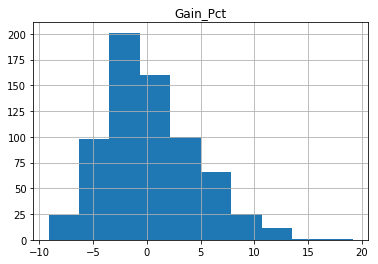

In [23]:
stock_trades.hist('Gain_Pct')

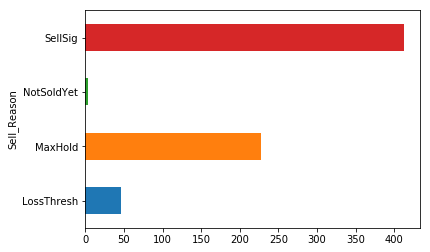

In [24]:
reason_counts = stock_trades.groupby('Sell_Reason').size()

reason_counts.plot('barh')